# Calibrating and Time Binning Astronomical Data

**UPDATE 14.08**: We have updated the calibration steps in the notebook. We understand that some of you have been using the old calibration procedure. The old procedures still provide a good estimate of the transit depth over different wavelengths, but as competition hosts we understand the difficulty to accurately calibrate the data product (even for us, it is still a learning journey, afterall, we are preparing for the mission), and we want to make sure you have the most updated knowledge on the calibration pipeline, so that it helps your journey in tackling this challenge. We will explain more in our discussion 

**UPDATE 29.08**: We have added 0.1s to the integration time for both AIRS and FGS observations. They are important when accounting for the contributing of dark frames when calibration the image. The modification, however, should not affect too much of the calibrated product. 

Data reduction is crucial in astronomical observations, and this challenge is no exception. This notebook outlines essential calibration steps typically employed by astronomers to mitigate noise in data.

Key points:

- The notebook guides participants through pre-processing data and saving it in a more convenient, lighter format.
- If you plan to use the baseline models (which will be released soon), you must run this notebook first before training.

Important note: While these steps help reduce noise and data size, they may not be the most effective approach for achieving the optimal model for this challenge. Participants are encouraged to explore alternative methods that could yield better results.





**Acknowledgement**: This notebook is prepared by Angèle Syty and Virginie Batista (IAP), with support from Andrea Bocchieri, Orphée Faucoz (CNES), Lorenzo V. Mugnai (Cardiff University & UCL), Tara Tahseen (UCL), Gordon Yip (UCL).

Last modified: 29 Aug 2024. 

In [14]:
import numpy as np
import pandas as pd
import itertools
import os
import glob
from astropy.stats import sigma_clip

from tqdm import tqdm

Below, we define the corrections we want to apply, the size of the data chunks and the different path used to import data and save the light ones. 

In [16]:
# path to the folder containing the data
path_folder = "../dataset/ariel-data-challenge-2024/"

# path to the folder to store the light data
path_out = "../output/data_light_raw/"

If the *path_out* folder doesn't exist yet, it is created. 

In [3]:
if not os.path.exists(path_out):
    os.makedirs(path_out)
    print(f"Directory {path_out} created.")
else:
    print(f"Directory {path_out} already exists.")

Directory ../output/data_light_raw/ already exists.


**Data import:**

 The files are imported by chunks of size 'CHUNK_SIZE' to avoid exceeding the memory capacity. 

In [17]:
CHUNKS_SIZE = 1

# set -1 to process all files
TEST_FILE_NUM = 22

# AIRS provides higher-resolution data
# FGS1 provides higher temporal resolution (more frequent time steps, 12 times)
# AIRS and FGS1 data will have same time resolution after binning
AIRS_binning = 30
FGS1_binning = 30 * 12

DO_MASK = True
DO_THE_NL_CORR = False # TODO: baseline method didn't do non-linearity correction
DO_DARK = True
DO_FLAT = True
TIME_BINNING = True

cut_inf, cut_sup = 39, 321
l = cut_sup - cut_inf

## Step 1: Analog-to-Digital Conversion

The Analog-to-Digital Conversion (adc) is performed by the detector to convert the pixel voltage into an integer number. We revert this operation by using the gain and offset for the calibration files 'train_adc_info.csv'.


In [5]:
def ADC_convert(signal, gain, offset):
    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset
    return signal

## Step 2: Mask hot/dead pixel
The dead pixels map is a map of the pixels that do not respond to light and, thus, can’t be accounted for any calculation. In all these frames the dead pixels are masked using python masked arrays. The bad pixels are thus masked but left uncorrected. Some methods can be used to correct bad-pixels but this task, if needed, is left to the participants.

In [6]:
def mask_hot_dead(signal, dead, dark):
    hot = sigma_clip(dark, sigma=5, maxiters=5).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)
    return signal

## Step 2: linearity Correction



**Non-linearity of pixels' response:**

The non-linearity of the pixels’ response can be explained as capacitive leakage on the readout electronics of each pixel during the integration time. The number of electrons in the well is proportional to the number of photons that hit the pixel, with a quantum efficiency coefficient. However, the response of the pixel is not linear with the number of electrons in the well. This effect can be described by a polynomial function of the number of electrons actually in the well. The data is provided with calibration files linear_corr.parquet that are the coefficients of the inverse polynomial function and can be used to correct this non-linearity effect.



In [7]:
def apply_linear_corr(linear_corr, clean_signal):
    linear_corr = np.flip(linear_corr, axis=0)
    for x, y in itertools.product(
        range(clean_signal.shape[1]), range(clean_signal.shape[2])
    ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    return clean_signal

## Step 3: dark current subtraction

The data provided include calibration for dark current estimation, which can be used to pre-process the observations. Dark current represents a constant signal that accumulates in each pixel during the integration time, independent of the incoming light. To obtain the corrected image, the following conventional approach is applied: The data provided include calibration files such as dark frames or dead pixels' maps. They can be used to pre-process the observations. The dark frame is a map of the detector response to a very short exposure time, to correct for the dark current of the detector.
$$\text{image - dark} \times \Delta t $$ 
The corrected image is conventionally obtained via the following: where the dark current map is first corrected for the dead pixel.

In [8]:
def clean_dark(signal, dead, dark, dt):

    dark = np.ma.masked_where(dead, dark)
    dark = np.tile(dark, (signal.shape[0], 1, 1))

    signal -= dark * dt[:, np.newaxis, np.newaxis]
    return signal

## Step 4: Get Correlated Double Sampling (CDS)

The science frames are alternating between the start of the exposure and the end of the exposure. The lecture scheme is a ramp with a double sampling, called Correlated Double Sampling (CDS), the detector is read twice, once at the start of the exposure and once at the end of the exposure. The final CDS is the difference (End of exposure) - (Start of exposure).

In [9]:
def get_cds(signal):
    cds = signal[:, 1::2, :, :] - signal[:, ::2, :, :]
    return cds

## Step 5 (Optional): Time Binning
This step is performed mainly to save space. Time series observations are binned together at specified frequency.

Note: Binning also helps reduce the random noise in the data by averaging multiple time steps



In [10]:
def bin_obs(cds_signal, binning):
    # swap the height and width axis
    cds_transposed = cds_signal.transpose(0, 1, 3, 2)

    # binning the time step axis
    cds_binned = np.zeros(
        (
            cds_transposed.shape[0],
            cds_transposed.shape[1] // binning,
            cds_transposed.shape[2],
            cds_transposed.shape[3],
        )
    )

    # iterate over the time steps in chunks of binning size,
    # summing the flux values for each bin across the binning number of consecutive time steps
    for i in range(cds_transposed.shape[1] // binning):
        cds_binned[:, i, :, :] = np.sum(
            cds_transposed[:, i * binning : (i + 1) * binning, :, :], axis=1
        )

    return cds_binned

## Step 6: Flat Field Correction


The flat field is a map of the detector response to uniform illumination, to correct for the pixel-to-pixel variations of the detector, for example the different quantum efficiencies of each pixel.

In [11]:
def correct_flat_field(flat, dead, signal):
    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal = signal / flat
    return signal

# Calibrating all training data

you can choose to correct the non-linearity of the pixels' response, to apply flat field, dark and dead map or to leave the data unchanged. The observations are binned in time by group of 30 frames for AIRS and 360 frames for FGS1, to obtain a lighter data-cube, easier to use. The images are cut along the wavelength axis between pixels 39 and 321, so that the 282 pixels left in the wavelength dimension match the last 282 targets' points, from AIRS. The 283rd targets' point is the one for FGS1 that will be added later on. 

In [19]:
## we will start by getting the index of the training data:
def get_index(files, CHUNKS_SIZE):
    index = []
    for file in files:
        file_name = file.split("/")[-1]
        if (
            file_name.split("_")[0] == "AIRS-CH0"
            and file_name.split("_")[1] == "signal.parquet"
        ):
            file_index = os.path.basename(os.path.dirname(file))
            index.append(int(file_index))
    index = np.array(index)
    index = np.sort(index)
    # credit to DennisSakva
    index = np.array_split(index, len(index) // CHUNKS_SIZE)

    return index

In [20]:
files = glob.glob(os.path.join(path_folder + "train/", "*/*"))

# get the index of planet_id, and split it into chunks
index = get_index(
    files[: len(files) if TEST_FILE_NUM == -1 else TEST_FILE_NUM], CHUNKS_SIZE
)

In [13]:
# load train_adc_info and set the index to planet_id
train_adc_info = pd.read_csv(os.path.join(path_folder, "train_adc_info.csv"))
train_adc_info = train_adc_info.set_index("planet_id")
# train_adc_info: [673 rows x 5 columns (planet_id, AIRS-CH0_adc_gain, AIRS-CH0_adc_offset, FGS1_adc_gain, FGS1_adc_offset)]

# load axis_info
axis_info = pd.read_parquet(os.path.join(path_folder, "axis_info.parquet"))

# iterate over the chunks
for n, index_chunk in enumerate(tqdm(index)):

    AIRS_CH0_clean = np.zeros((CHUNKS_SIZE, 11250, 32, l))
    FGS1_clean = np.zeros((CHUNKS_SIZE, 135000, 32, 32))

    # iterate within a chunk
    for i in range(CHUNKS_SIZE):

        # LOAD AIRS DATA
        # original shape: (11250, 11392)
        df = pd.read_parquet(
            os.path.join(path_folder, f"train/{index_chunk[i]}/AIRS-CH0_signal.parquet")
        )
        signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))

        # adc reversion using the gain and offset
        gain = train_adc_info["AIRS-CH0_adc_gain"].loc[index_chunk[i]]
        offset = train_adc_info["AIRS-CH0_adc_offset"].loc[index_chunk[i]]
        signal = ADC_convert(signal, gain, offset)

        # TODO: check this
        dt_airs = axis_info["AIRS-CH0-integration_time"].dropna().values
        dt_airs[1::2] += 0.1

        # cut AIRS signal along the wavelength axis
        chopped_signal = signal[:, :, cut_inf:cut_sup]

        del signal, df

        # CLEANING THE DATA: AIRS
        # original shape:
        #   - flat: (32, 356)
        #   - dark: (32, 356)
        #   - dead_airs: (32, 356)
        #   - linear_corr: (192, 356). 6th-order polynomial coefficients
        flat = (
            pd.read_parquet(
                os.path.join(
                    path_folder,
                    f"train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet",
                )
            )
            .values.astype(np.float64)
            .reshape((32, 356))[:, cut_inf:cut_sup]
        )
        dark = (
            pd.read_parquet(
                os.path.join(
                    path_folder,
                    f"train/{index_chunk[i]}/AIRS-CH0_calibration/dark.parquet",
                )
            )
            .values.astype(np.float64)
            .reshape((32, 356))[:, cut_inf:cut_sup]
        )
        dead_airs = (
            pd.read_parquet(
                os.path.join(
                    path_folder,
                    f"train/{index_chunk[i]}/AIRS-CH0_calibration/dead.parquet",
                )
            )
            .values.astype(np.float64)
            .reshape((32, 356))[:, cut_inf:cut_sup]
        )
        linear_corr = (
            pd.read_parquet(
                os.path.join(
                    path_folder,
                    f"train/{index_chunk[i]}/AIRS-CH0_calibration/linear_corr.parquet",
                )
            )
            .values.astype(np.float64)
            .reshape((6, 32, 356))[:, :, cut_inf:cut_sup]
        )

        if DO_MASK:
            chopped_signal = mask_hot_dead(chopped_signal, dead_airs, dark)
            AIRS_CH0_clean[i] = chopped_signal
        else:
            AIRS_CH0_clean[i] = chopped_signal

        if DO_THE_NL_CORR:
            linear_corr_signal = apply_linear_corr(linear_corr, AIRS_CH0_clean[i])
            AIRS_CH0_clean[i, :, :, :] = linear_corr_signal
        del linear_corr

        if DO_DARK:
            cleaned_signal = clean_dark(AIRS_CH0_clean[i], dead_airs, dark, dt_airs)
            AIRS_CH0_clean[i] = cleaned_signal
        else:
            pass
        del dark, chopped_signal

        # LOAD FGS1 DATA
        # original shape: (135000, 1024)
        df = pd.read_parquet(
            os.path.join(path_folder, f"train/{index_chunk[i]}/FGS1_signal.parquet")
        )
        fgs_signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 32))

        # adc reversion using the gain and offset
        FGS1_gain = train_adc_info["FGS1_adc_gain"].loc[index_chunk[i]]
        FGS1_offset = train_adc_info["FGS1_adc_offset"].loc[index_chunk[i]]
        fgs_signal = ADC_convert(fgs_signal, FGS1_gain, FGS1_offset)

        # TODO: check this
        dt_fgs1 = np.ones(len(fgs_signal)) * 0.1
        dt_fgs1[1::2] += 0.1

        chopped_FGS1 = fgs_signal

        del fgs_signal, df

        # CLEANING THE DATA: FGS1
        flat = (
            pd.read_parquet(
                os.path.join(
                    path_folder, f"train/{index_chunk[i]}/FGS1_calibration/flat.parquet"
                )
            )
            .values.astype(np.float64)
            .reshape((32, 32))
        )
        dark = (
            pd.read_parquet(
                os.path.join(
                    path_folder, f"train/{index_chunk[i]}/FGS1_calibration/dark.parquet"
                )
            )
            .values.astype(np.float64)
            .reshape((32, 32))
        )
        dead_fgs1 = (
            pd.read_parquet(
                os.path.join(
                    path_folder, f"train/{index_chunk[i]}/FGS1_calibration/dead.parquet"
                )
            )
            .values.astype(np.float64)
            .reshape((32, 32))
        )
        linear_corr = (
            pd.read_parquet(
                os.path.join(
                    path_folder,
                    f"train/{index_chunk[i]}/FGS1_calibration/linear_corr.parquet",
                )
            )
            .values.astype(np.float64)
            .reshape((6, 32, 32))
        )

        if DO_MASK:
            chopped_FGS1 = mask_hot_dead(chopped_FGS1, dead_fgs1, dark)
            FGS1_clean[i] = chopped_FGS1
        else:
            FGS1_clean[i] = chopped_FGS1

        if DO_THE_NL_CORR:
            linear_corr_signal = apply_linear_corr(linear_corr, FGS1_clean[i])
            FGS1_clean[i, :, :, :] = linear_corr_signal
        del linear_corr

        if DO_DARK:
            cleaned_signal = clean_dark(FGS1_clean[i], dead_fgs1, dark, dt_fgs1)
            FGS1_clean[i] = cleaned_signal
        else:
            pass
        del dark, chopped_FGS1

    # SAVE DATA AND FREE SPACE (after processing each chunk)
    # frame number reduce to half after CDS
    # shape:
    #   - AIRS_CH0_clean: (CHUNKS_SIZE, 11250, 32, 282)
    #   - FGS1_clean: (CHUNKS_SIZE, 135000, 32, 32)
    #   - AIRS_cds: (CHUNKS_SIZE, 5625, 32, 282)
    #   - FGS1_cds: (CHUNKS_SIZE, 67500, 32, 32)
    AIRS_cds = get_cds(AIRS_CH0_clean)
    FGS1_cds = get_cds(FGS1_clean)

    del AIRS_CH0_clean, FGS1_clean

    ## (Optional) Time Binning to reduce space
    if TIME_BINNING:
        AIRS_cds_binned = bin_obs(AIRS_cds, binning=AIRS_binning)
        FGS1_cds_binned = bin_obs(FGS1_cds, binning=FGS1_binning)
    else:
        # transpose is important to make it consistent for flat fielding, but you can always change it
        AIRS_cds = AIRS_cds.transpose(0, 1, 3, 2)
        AIRS_cds_binned = AIRS_cds
        FGS1_cds = FGS1_cds.transpose(0, 1, 3, 2)
        FGS1_cds_binned = FGS1_cds

    del AIRS_cds, FGS1_cds

    # TODO: why flat after binning?
    if DO_FLAT:
        for i in range(CHUNKS_SIZE):
            flat_airs = (
                pd.read_parquet(
                    os.path.join(
                        path_folder,
                        f"train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet",
                    )
                )
                .values.astype(np.float64)
                .reshape((32, 356))[:, cut_inf:cut_sup]
            )
            flat_fgs = (
                pd.read_parquet(
                    os.path.join(
                        path_folder,
                        f"train/{index_chunk[i]}/FGS1_calibration/flat.parquet",
                    )
                )
                .values.astype(np.float64)
                .reshape((32, 32))
            )
            AIRS_cds_binned[i] = correct_flat_field(
                flat_airs, dead_airs, AIRS_cds_binned[i]
            )
            FGS1_cds_binned[i] = correct_flat_field(
                flat_fgs, dead_fgs1, FGS1_cds_binned[i]
            )
    else:
        pass

    ## save data
    np.save(
        os.path.join(path_out, "AIRS_clean_train_{}.npy".format(n)), AIRS_cds_binned
    )
    np.save(os.path.join(path_out, "FGS1_train_{}.npy".format(n)), FGS1_cds_binned)

    del AIRS_cds_binned, FGS1_cds_binned

100%|██████████| 6/6 [01:51<00:00, 18.54s/it]


Once all the chunks are saved, we concatenate them back in a single dataset. This step is simply to save HDD space, modify it as you wish. 

In [21]:
def load_data(file, chunk_size, nb_files):
    data0 = np.load(file + "_0.npy")
    data_all = np.zeros(
        (nb_files * chunk_size, data0.shape[1], data0.shape[2], data0.shape[3])
    )
    data_all[:chunk_size] = data0
    for i in range(1, nb_files):
        data_all[i * chunk_size : (i + 1) * chunk_size] = np.load(
            file + "_{}.npy".format(i)
        )
    return data_all


data_train = load_data(path_out + "AIRS_clean_train", CHUNKS_SIZE, len(index))
data_train_FGS = load_data(path_out + "FGS1_train", CHUNKS_SIZE, len(index))

np.save(path_out + "data_train.npy", data_train)
np.save(path_out + "data_train_FGS.npy", data_train_FGS)

# Plots

Let us checks that everything went well during the data import. 

In [22]:
import matplotlib.pyplot as plt

print("Shape of the training dataset: \t")
print("\n For AIRS-CH0:", data_train.shape)
print("\n For FGS1:", data_train_FGS.shape)

Shape of the training dataset: 	

 For AIRS-CH0: (6, 187, 282, 32)

 For FGS1: (6, 187, 32, 32)


Plot of some images: 

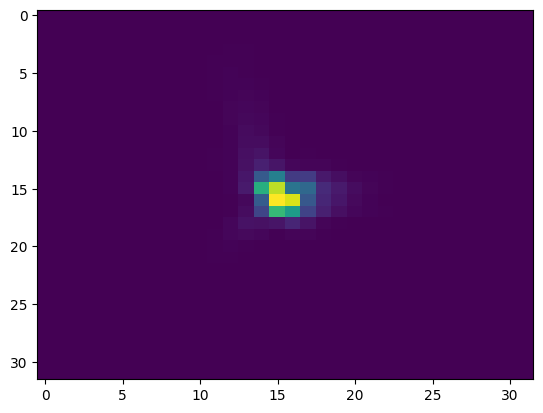

In [23]:
# 50th frame of the last chunk (observation), pixel value representing the flux
# transpose the weight and height back to the original shape
plt.imshow(data_train_FGS[-1, 50, :, :].T, aspect="auto")

Plot of some light-curves: 

1. Exoplanetary Transit:
    - An exoplanetary transit occurs when a planet passes in front of its host star as seen from the telescope's viewpoint. During this event, the planet blocks some portion of the star’s light, reducing the observed flux (brightness).
    - The light curve captures this event as a drop in the total flux (the brightness of the star).

2. Shape of the Transit Light Curve:
The shape of a typical transit light curve has three main phases:
    - **Out of Transit (High Flux)**: Before and after the planet transits the star, the light from the star is unblocked, and the observed flux is at its maximum. This corresponds to the flat high regions in the light curve plot.
    - **Ingress and Egress (Transition)**: These are the periods when the planet starts moving in front of the star (ingress) and when it starts moving out of the transit (egress). During these periods, the light curve begins to drop rapidly. This causes the sharp downward slopes at the edges of the light curve.
    - **Mid-Transit (Low Flux)**: When the planet is fully in front of the star, the flux reaches its minimum value. This results in the flat low region of the light curve, forming the "gate" or plateau-like shape.

Text(0, 0.5, 'Normalized flux in the frame')

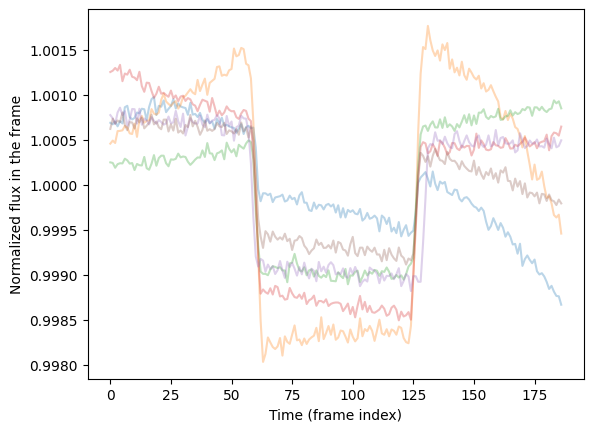

In [24]:
# iterate over chunks of AIRS data
for i in range(len(data_train)):

    # for each chunk,
    # 1. sum up the single frames along the weight and height axis to a flux value, as a function of time
    # 2. normalize the flux values by the mean flux value
    light_curve = data_train[i, :, :, :].sum(axis=(1, 2))
    plt.plot(light_curve / light_curve.mean(), "-", alpha=0.3)

plt.xlabel("Time (frame index)")
plt.ylabel("Normalized flux in the frame")